# NYC Green Taxi research 

В данном задании я буду исследовать данные по поездкам такси в Нью-Йорке за декабрь 2019 и январь 2020 года. Данные можно скачать [тут](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page).

Я буду отвечать на следующие вопросы и делать задания:

1. Найти аномальные поездки. Объянить, почему именно эти поездки можно считать аномальными?
2. Как стоимость поездки скоррелирована с другими факторами? Как это можно объяснить?
3. Построить распределение по стоимости поездок. Проверить гипотезу о том, что оно имеет нормальное распределение. Как это можно объяснить?
4. Построить модель, которая описывает тариф (т.е. стоимость поездки от определенных факторов).

Расшифровка названий столбцов:
- VendorID - Код, указывающий поставщика LPEP, предоставившего запись
- lpep_pickup_datetime - Дата и время, когда счетчик был включен
- lpep_dropoff_datetime - Дата и время, когда счетчик был отключен
- Passenger_count - Количество пассажиров в транспортном средстве.
- Trip_distance - Пройденное расстояние в милях, показанное таксометром.
- PULocationID - Зона такси TLC, в которой был задействован таксометр
- DOLocationID - Зона такси TLC, в которой был отключен таксометр
- RateCodeID - Окончательный код тарифа, действующий в конце поездки:
  - 1= Standard rate
  - 2=JFK
  - 3=Newark
  - 4=Nassau or Westchester
  - 5=Negotiated fare
  - 6=Group rid
- Store_and_fwd_flag - Этот флаг указывает, сохранялась ли запись о поездке в памяти транспортного средства перед отправкой поставщику, она же “хранить и пересылать”, поскольку транспортное средство не имело подключения к серверу.
- Payment_type - Цифровой код, указывающий, как пассажир оплатил поездку:
  - 1= Credit card
  - 2= Cash
  - 3= No charge
  - 4= Dispute
  - 5= Unknown
  - 6= Voided trip
- Fare_amount - Стоимость проезда по времени и расстоянию рассчитывается с помощью счетчика
- Extra - Различные дополнительные услуги и доплаты. В настоящее время это включает в себя только сборы за час пик в размере 0,50 и 1 доллар США и сборы за ночь
- MTA_tax - Налог в размере 0,50 млн долларов США, который автоматически запускается в зависимости от используемой учетной ставки
- Improvement_surcharge - Надбавка за улучшение в размере 0,30 доллара США, начисляемая за приветствуемые поездки при сбросе флага. Надбавка за благоустройство начала взиматься в 2015 году
- Tip_amount - Сумма чаевых –Это поле автоматически заполняется для чаевых по кредитной карте. Чаевые наличными не включены.
- Tolls_amount - Общая сумма всех сборов, оплаченных в поездке.
- Total_amount - Общая сумма, взимаемая с пассажиров. Не включает чаевые наличными.
- Trip_type - Код, указывающий, была ли поездка уличной или отправкой, который автоматически присваивается в зависимости от используемого тарифа, но может быть изменен водителем:
   - 1= Street-hail
   - 2= Dispatch

In [1]:
import pandas as pd
import pickle
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from datetime import datetime
import math
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.metrics import make_scorer
from sklearn.linear_model import ElasticNetCV
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

pd.options.display.max_columns = 999

In [2]:
data_19 = pd.read_csv('~/Documents/Python/green_tripdata_2019-12.csv')
data_19.head()
                  

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,1.0,2019-12-01 00:09:45,2019-12-01 00:10:59,N,1.0,145,145,1.0,0.00,3.0,0.5,0.5,0.00,0.0,NaN,0.3,4.30,2.0,1.0,0.0
1,2.0,2019-12-01 00:26:05,2019-12-01 00:31:30,N,1.0,24,41,1.0,0.67,5.5,0.5,0.5,2.04,0.0,NaN,0.3,8.84,1.0,1.0,0.0
2,2.0,2019-12-01 00:56:36,2019-12-01 00:59:38,N,1.0,74,41,1.0,0.61,4.5,0.5,0.5,0.00,0.0,NaN,0.3,5.80,2.0,1.0,0.0
3,2.0,2019-12-01 00:26:20,2019-12-01 00:40:19,N,1.0,255,157,1.0,3.90,14.0,0.5,0.5,0.00,0.0,NaN,0.3,15.30,2.0,1.0,0.0
4,2.0,2019-12-01 00:56:36,2019-12-01 00:59:56,N,1.0,80,255,1.0,0.50,4.5,0.5,0.5,0.00,0.0,NaN,0.3,5.80,2.0,1.0,0.0


In [3]:
data_19.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450627 entries, 0 to 450626
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   VendorID               359902 non-null  float64
 1   lpep_pickup_datetime   450627 non-null  object 
 2   lpep_dropoff_datetime  450627 non-null  object 
 3   store_and_fwd_flag     359902 non-null  object 
 4   RatecodeID             359902 non-null  float64
 5   PULocationID           450627 non-null  int64  
 6   DOLocationID           450627 non-null  int64  
 7   passenger_count        359902 non-null  float64
 8   trip_distance          450627 non-null  float64
 9   fare_amount            450627 non-null  float64
 10  extra                  450627 non-null  float64
 11  mta_tax                450627 non-null  float64
 12  tip_amount             450627 non-null  float64
 13  tolls_amount           450627 non-null  float64
 14  ehail_fee              0 non-null   

In [4]:
data_20 = pd.read_csv('~/Documents/Python/green_tripdata_2020-01.csv')
data_20.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2.0,2019-12-18 15:52:30,2019-12-18 15:54:39,N,1.0,264,264,5.0,0.00,3.5,0.50,0.5,0.01,0.0,NaN,0.3,4.81,1.0,1.0,0.00
1,2.0,2020-01-01 00:45:58,2020-01-01 00:56:39,N,5.0,66,65,2.0,1.28,20.0,0.00,0.0,4.06,0.0,NaN,0.3,24.36,1.0,2.0,0.00
2,2.0,2020-01-01 00:41:38,2020-01-01 00:52:49,N,1.0,181,228,1.0,2.47,10.5,0.50,0.5,3.54,0.0,NaN,0.3,15.34,1.0,1.0,0.00
3,1.0,2020-01-01 00:52:46,2020-01-01 01:14:21,N,1.0,129,263,2.0,6.30,21.0,3.25,0.5,0.00,0.0,NaN,0.3,25.05,2.0,1.0,2.75
4,1.0,2020-01-01 00:19:57,2020-01-01 00:30:56,N,1.0,210,150,1.0,2.30,10.0,0.50,0.5,0.00,0.0,NaN,0.3,11.30,1.0,1.0,0.00


In [5]:
data_20.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447770 entries, 0 to 447769
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   VendorID               331719 non-null  float64
 1   lpep_pickup_datetime   447770 non-null  object 
 2   lpep_dropoff_datetime  447770 non-null  object 
 3   store_and_fwd_flag     331719 non-null  object 
 4   RatecodeID             331719 non-null  float64
 5   PULocationID           447770 non-null  int64  
 6   DOLocationID           447770 non-null  int64  
 7   passenger_count        331719 non-null  float64
 8   trip_distance          447770 non-null  float64
 9   fare_amount            447770 non-null  float64
 10  extra                  447770 non-null  float64
 11  mta_tax                447770 non-null  float64
 12  tip_amount             447770 non-null  float64
 13  tolls_amount           447770 non-null  float64
 14  ehail_fee              0 non-null   

In [6]:
# объединяем таблицы data_19 и data_20
data = data_19.append(data_20)

In [7]:
data.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,1.0,2019-12-01 00:09:45,2019-12-01 00:10:59,N,1.0,145,145,1.0,0.00,3.0,0.5,0.5,0.00,0.0,NaN,0.3,4.30,2.0,1.0,0.0
1,2.0,2019-12-01 00:26:05,2019-12-01 00:31:30,N,1.0,24,41,1.0,0.67,5.5,0.5,0.5,2.04,0.0,NaN,0.3,8.84,1.0,1.0,0.0
2,2.0,2019-12-01 00:56:36,2019-12-01 00:59:38,N,1.0,74,41,1.0,0.61,4.5,0.5,0.5,0.00,0.0,NaN,0.3,5.80,2.0,1.0,0.0
3,2.0,2019-12-01 00:26:20,2019-12-01 00:40:19,N,1.0,255,157,1.0,3.90,14.0,0.5,0.5,0.00,0.0,NaN,0.3,15.30,2.0,1.0,0.0
4,2.0,2019-12-01 00:56:36,2019-12-01 00:59:56,N,1.0,80,255,1.0,0.50,4.5,0.5,0.5,0.00,0.0,NaN,0.3,5.80,2.0,1.0,0.0


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 898397 entries, 0 to 447769
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   VendorID               691621 non-null  float64
 1   lpep_pickup_datetime   898397 non-null  object 
 2   lpep_dropoff_datetime  898397 non-null  object 
 3   store_and_fwd_flag     691621 non-null  object 
 4   RatecodeID             691621 non-null  float64
 5   PULocationID           898397 non-null  int64  
 6   DOLocationID           898397 non-null  int64  
 7   passenger_count        691621 non-null  float64
 8   trip_distance          898397 non-null  float64
 9   fare_amount            898397 non-null  float64
 10  extra                  898397 non-null  float64
 11  mta_tax                898397 non-null  float64
 12  tip_amount             898397 non-null  float64
 13  tolls_amount           898397 non-null  float64
 14  ehail_fee              0 non-null   

In [9]:
#удаляем столбцы VendorID, ehail_fee, store_and_fwd_flag
data = data.drop(labels=['VendorID','ehail_fee', 'store_and_fwd_flag'], axis=1)

In [10]:
# меняем тип данных у столбца lpep_pickup_datetime  
data['lpep_pickup_datetime'] = pd.to_datetime(data['lpep_pickup_datetime'])

# меняем тип данных у столбца lpep_dropoff_datetime 
data['lpep_dropoff_datetime'] = pd.to_datetime(data['lpep_dropoff_datetime'])

In [11]:
# узнаем моду столбца passenger_count
data['passenger_count'].mode()

0    1.0
dtype: float64

In [12]:
# заменим значения NaN в столбце congestion_surcharge на 0 
data['congestion_surcharge'] = data['congestion_surcharge'].fillna(0)

# заменим значения NaN в столбце trip_type на 0 
data['trip_type'] = data['trip_type'].fillna(0)

# заменим значения NaN в столбце payment_type на значение 5 (то есть тип оплаты неизвестен)
data['payment_type'] = data['payment_type'].fillna(5)

# заменим значения NaN в столбце passenger_count на моду по этому столбцу
data['passenger_count'] = data['passenger_count'].fillna(1)

# заменим значения NaN в столбце RatecodeID на 0 
data['RatecodeID'] = data['RatecodeID'].fillna(0)

# заменим значения NaN в столбце improvement_surcharge на 0.3 (самое распространенное)
data['improvement_surcharge'] = data['improvement_surcharge'].fillna(0.3)


In [13]:
data.isnull().sum()

lpep_pickup_datetime     0
lpep_dropoff_datetime    0
RatecodeID               0
PULocationID             0
DOLocationID             0
passenger_count          0
trip_distance            0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
payment_type             0
trip_type                0
congestion_surcharge     0
dtype: int64

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 898397 entries, 0 to 447769
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   lpep_pickup_datetime   898397 non-null  datetime64[ns]
 1   lpep_dropoff_datetime  898397 non-null  datetime64[ns]
 2   RatecodeID             898397 non-null  float64       
 3   PULocationID           898397 non-null  int64         
 4   DOLocationID           898397 non-null  int64         
 5   passenger_count        898397 non-null  float64       
 6   trip_distance          898397 non-null  float64       
 7   fare_amount            898397 non-null  float64       
 8   extra                  898397 non-null  float64       
 9   mta_tax                898397 non-null  float64       
 10  tip_amount             898397 non-null  float64       
 11  tolls_amount           898397 non-null  float64       
 12  improvement_surcharge  898397 non-null  floa

## Аномальные поездки

Далее исследуем аномальные поздки. Для этого создадим новые признаки на основании уже имеющихся, посмотрим по ним статистику и изобразим их графически.

In [15]:
# создаем столцец с информацием о часе, в котором началась поездка
data['hour_start'] = data['lpep_pickup_datetime'].dt.hour

In [16]:
#cоздаем столцец с днями недели по названию
data['day_of_week'] = data['lpep_pickup_datetime'].dt.day_name()

In [17]:
#cоздаем столцец с днями недели Monday=0, Sunday=6.
data['num_day_of_week'] = data['lpep_pickup_datetime'].dt.dayofweek

In [18]:
# создаем столбец с продолжительность поездки
data['duration_of_trip'] = data['lpep_dropoff_datetime'] - data['lpep_pickup_datetime']

In [19]:
# переводим продолжительность поездки в количество минут
data['duration_of_trip_min'] = data['duration_of_trip'] / np.timedelta64(1, 'm')

# переводим продолжительность поездки в количество минут
data['duration_of_trip_hour'] = data['duration_of_trip'] / np.timedelta64(1, 'h')

In [20]:
data.head(10)

,lpep_pickup_datetime,lpep_dropoff_datetime,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,hour_start,day_of_week,num_day_of_week,duration_of_trip,duration_of_trip_min,duration_of_trip_hour
0,2019-12-01 00:09:45,2019-12-01 00:10:59,1.0,145,145,1.0,0.00,3.0,0.5,0.5,0.00,0.00,0.3,4.30,2.0,1.0,0.00,0,Sunday,6,0 days 00:01:14,1.233333,0.020556
1,2019-12-01 00:26:05,2019-12-01 00:31:30,1.0,24,41,1.0,0.67,5.5,0.5,0.5,2.04,0.00,0.3,8.84,1.0,1.0,0.00,0,Sunday,6,0 days 00:05:25,5.416667,0.090278
2,2019-12-01 00:56:36,2019-12-01 00:59:38,1.0,74,41,1.0,0.61,4.5,0.5,0.5,0.00,0.00,0.3,5.80,2.0,1.0,0.00,0,Sunday,6,0 days 00:03:02,3.033333,0.050556
3,2019-12-01 00:26:20,2019-12-01 00:40:19,1.0,255,157,1.0,3.90,14.0,0.5,0.5,0.00,0.00,0.3,15.30,2.0,1.0,0.00,0,Sunday,6,0 days 00:13:59,13.983333,0.233056
4,2019-12-01 00:56:36,2019-12-01 00:59:56,1.0,80,255,1.0,0.50,4.5,0.5,0.5,0.00,0.00,0.3,5.80,2.0,1.0,0.00,0,Sunday,6,0 days 00:03:20,3.333333,0.055556
5,2019-12-01 00:14:28,2019-12-01 00:19:39,1.0,21,123,1.0,1.10,6.0,0.5,0.5,0.00,0.00,0.3,7.30,2.0,1.0,0.00,0,Sunday,6,0 days 00:05:11,5.183333,0.086389
6,2019-12-01 00:45:54,2019-12-01 00:52:46,1.0,181,228,1.0,1.50,7.5,0.5,0.5,0.00,0.00,0.3,8.80,2.0,1.0,0.00,0,Sunday,6,0 days 00:06:52,6.866667,0.114444
7,2019-12-01 00:25:35,2019-12-01 01:04:08,1.0,7,53,1.0,7.42,30.0,0.5,0.5,0.00,0.00,0.3,31.30,2.0,1.0,0.00,0,Sunday,6,0 days 00:38:33,38.550000,0.642500
8,2019-12-01 00:43:12,2019-12-01 00:56:44,1.0,75,223,1.0,5.30,16.5,0.5,0.5,0.00,6.12,0.3,23.92,2.0,1.0,0.00,0,Sunday,6,0 days 00:13:32,13.533333,0.225556
9,2019-12-01 00:56:08,2019-12-01 01:05:11,1.0,112,232,1.0,2.64,10.0,0.5,0.5,2.81,0.00,0.3,16.86,1.0,1.0,2.75,0,Sunday,6,0 days 00:09:03,9.050000,0.150833


In [21]:
#смотрим статистику по столбцу duration_of_trip_min
data['duration_of_trip_min'].describe()

count    898397.000000
mean         20.703498
std          78.636732
min          -0.166667
25%           7.000000
50%          12.066667
75%          21.000000
max        1439.966667
Name: duration_of_trip_min, dtype: float64

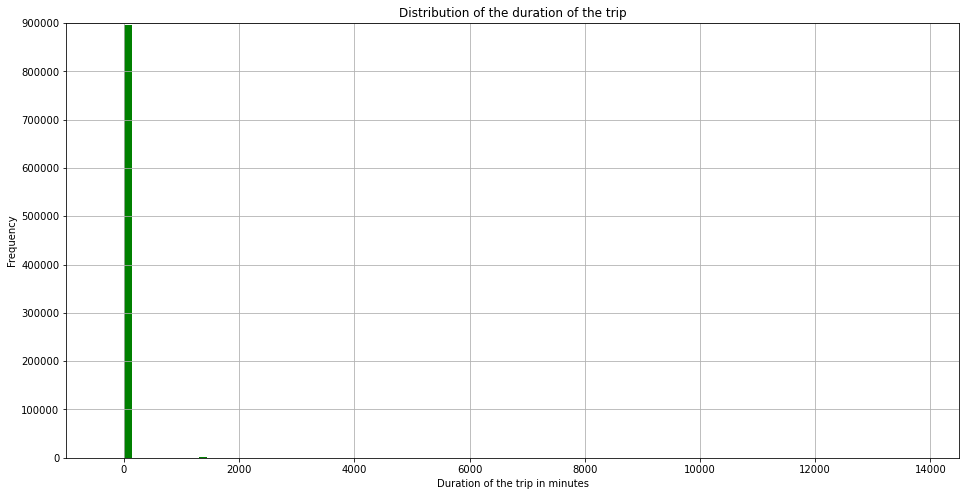

In [22]:
fig, ax = plt.subplots(figsize=(16,8))

plt.hist(data['duration_of_trip_min'], color='green')
plt.xlabel('Duration of the trip in minutes')
plt.ylabel('Frequency')
plt.title('Distribution of the duration of the trip')
plt.xlim(-1000, 14500)
plt.ylim(0, 900000)
plt.grid(True)
plt.show()


In [23]:
# посмотрим данные более детально, отделив поездки, которые длятся более 200 минут
between_200_1440 = data[(data['duration_of_trip_min'] > 200) & (data['duration_of_trip_min'] <1440)]
between_200_1440[['duration_of_trip_min', 'trip_distance', 'total_amount']].describe()

,duration_of_trip_min,trip_distance,total_amount
count,3460.000000,3460.000000,3460.000000
mean,1205.895959,3.797318,19.633853
std,383.104207,6.167302,28.885932
min,201.233333,-23.880000,-7.300000
25%,1307.362500,1.140000,8.800000
50%,1399.475000,2.080000,12.800000
75%,1422.729167,3.930000,20.050000
max,1439.966667,87.140000,488.800000


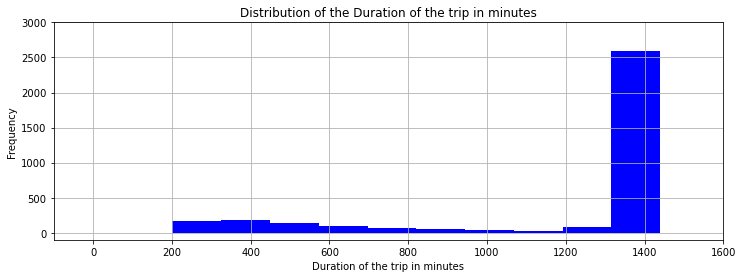

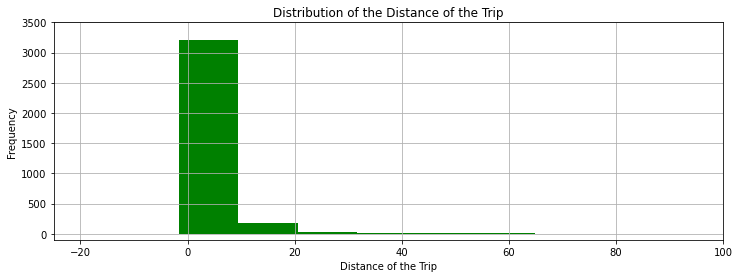

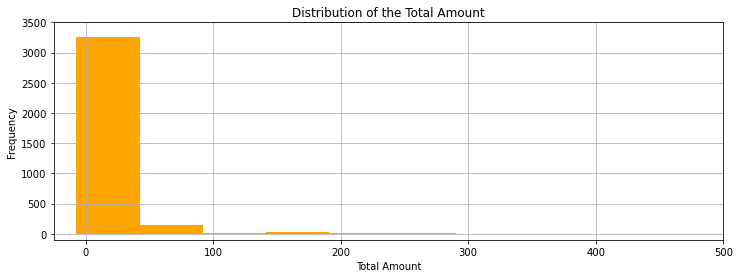

In [24]:
plt.figure(figsize=(12, 4))

plt.hist(between_200_1440['duration_of_trip_min'], color='blue')
plt.xlabel('Duration of the trip in minutes')
plt.ylabel('Frequency')
plt.title('Distribution of the Duration of the trip in minutes')
plt.xlim(-100, 1600)
plt.ylim(-100, 3000)
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 4))
plt.hist(between_200_1440['trip_distance'], color='green')
plt.xlabel('Distance of the Trip')
plt.ylabel('Frequency')
plt.title('Distribution of the Distance of the Trip')
plt.xlim(-25, 100)
plt.ylim(-100, 3500)
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 4))
plt.hist(between_200_1440['total_amount'], color='orange')
plt.xlabel('Total Amount')
plt.ylabel('Frequency')
plt.title('Distribution of the Total Amount')
plt.xlim(-25, 500)
plt.ylim(-100, 3500)
plt.grid(True)
plt.show()

Исходя из отобранных данных мы видим, что есть аномальные поездки длительностью даже более 6 часов, при этом стоимость может быть даже отрицательной и в целом основаня масса данных по стоимости находится в рамках до 50 долларов. Если рассматривать длину дистанции поездки, то можно также найти отрицательные значения и увидеть, что основаная масса значений по этому признаку попадает в интервал с от 0 до 10 миль. Эти данные кажутся неправдоподобными. 

Отрицательные значения могут быть связаны с ошибками в данных. Поэтому оставим данные, в которых trip_distance > 0 и total_amount > 0

In [25]:
# оставляем в основной таблице строки, в которых trip_distance > 0
data = data[data['trip_distance'] > 0]

In [26]:
data.shape

(865033, 23)

In [27]:
# оставляем в основной таблице строки, в которых total_amount > 0
data = data[data['total_amount'] > 0]

In [28]:
# проверим размер основной таблицы
data.shape

(861674, 23)

In [29]:
# проверим размер отобранных аномальных данных
between_200_1440.shape

(3460, 23)

In [30]:
# посмотрим данные с выбранными условиями
between_200_1440[(between_200_1440['duration_of_trip_min'] > 1000) & (between_200_1440['total_amount'] < 200)]

,lpep_pickup_datetime,lpep_dropoff_datetime,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,hour_start,day_of_week,num_day_of_week,duration_of_trip,duration_of_trip_min,duration_of_trip_hour
239,2019-12-01 00:20:11,2019-12-02 00:02:34,1.0,95,130,1.0,2.61,14.0,0.5,0.5,3.06,0.0,0.3,18.36,1.0,1.0,0.00,0,Sunday,6,0 days 23:42:23,1422.383333,23.706389
285,2019-12-01 00:09:24,2019-12-02 00:00:00,1.0,82,82,2.0,0.85,6.0,0.5,0.5,0.00,0.0,0.3,7.30,2.0,1.0,0.00,0,Sunday,6,0 days 23:50:36,1430.600000,23.843333
303,2019-12-01 00:36:46,2019-12-01 23:57:04,1.0,95,95,1.0,1.10,0.0,0.0,0.0,0.00,0.0,0.0,0.00,2.0,1.0,0.00,0,Sunday,6,0 days 23:20:18,1400.300000,23.338333
581,2019-12-01 01:43:59,2019-12-02 01:36:59,1.0,25,144,1.0,2.81,12.5,0.5,0.5,0.00,0.0,0.3,16.55,2.0,1.0,2.75,1,Sunday,6,0 days 23:53:00,1433.000000,23.883333
673,2019-12-01 01:13:56,2019-12-02 01:04:12,1.0,82,82,1.0,1.49,7.0,0.5,0.5,0.00,0.0,0.3,8.30,2.0,1.0,0.00,1,Sunday,6,0 days 23:50:16,1430.266667,23.837778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330652,2020-01-31 22:05:19,2020-02-01 21:01:11,1.0,7,7,1.0,1.02,7.0,0.5,0.5,2.08,0.0,0.3,10.38,1.0,1.0,0.00,22,Friday,4,0 days 22:55:52,1375.866667,22.931111
330740,2020-01-31 22:21:24,2020-02-01 21:36:46,1.0,226,7,1.0,1.05,6.0,0.5,0.5,0.00,0.0,0.3,7.30,2.0,1.0,0.00,22,Friday,4,0 days 23:15:22,1395.366667,23.256111
331206,2020-01-31 23:41:29,2020-02-01 23:40:40,1.0,42,69,2.0,2.50,13.0,0.5,0.5,0.00,0.0,0.3,14.30,2.0,1.0,0.00,23,Friday,4,0 days 23:59:11,1439.183333,23.986389
331563,2020-01-31 23:13:48,2020-02-01 22:57:02,1.0,255,198,1.0,3.22,14.5,0.5,0.5,1.58,0.0,0.3,17.38,1.0,1.0,0.00,23,Friday,4,0 days 23:43:14,1423.233333,23.720556


У нас всё ещё остаются аномальные данные по продолжительности поездки (1200-1440 минут), при этом суммы оплат и дистации по таким поездкам весьма небольшие! Эти данные также могут быть связаны с ошибками. Или с форс-мажорными обстоятельствами. Мы можем узнать, не приходится ли эти данные на какие-либо праздники. Стоит еще предположить, что такая длительность поездки может быть связана с погодными условиями или загруженностью дорог.

## Корреляция стоимости поездки с другими факторами

<AxesSubplot:>

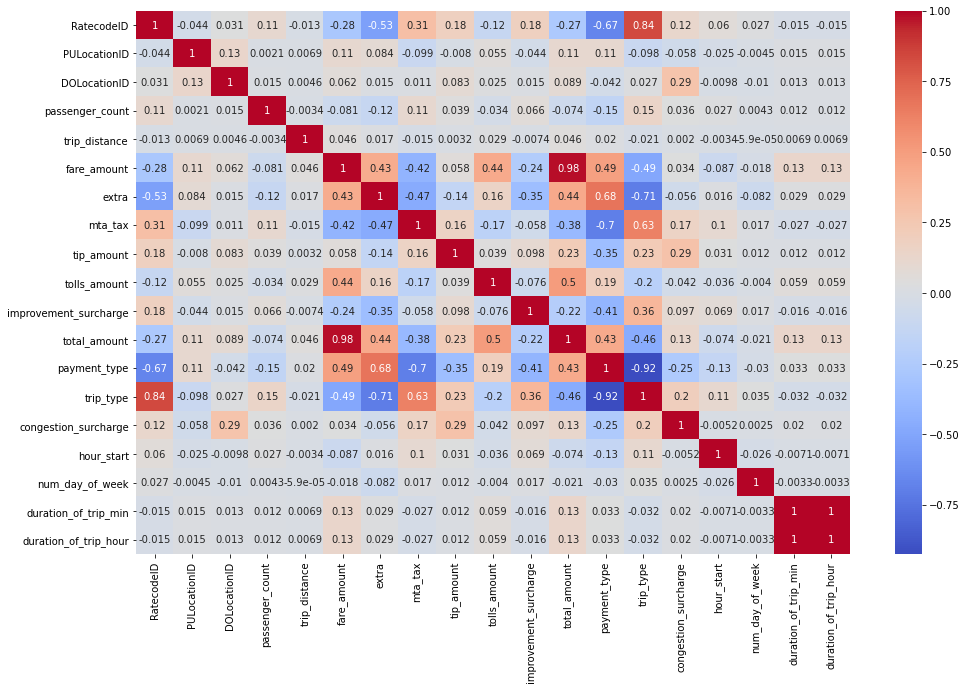

In [31]:
# выбраем типы int и float, исключаем строковые типы данных
numerical_data = data.select_dtypes(include=['int', 'float'])

#карта корреляции в виде таблицы
corrmat = numerical_data.corr()

# чертим карту
fig, ax = plt.subplots(figsize=(16,10))
sns.heatmap(corrmat, annot = True, cmap= 'coolwarm')

Исходя из карты корреляции заметно, что total_amount имеет взаимосвязь со стоимостью проезда по времени и расстоянию, которое рассчитывается с помощью счетчика, тут нет ничего удивительного: общая стоимость поездки действительно рассчитывается счетчиком, учитывая количество времени и расстояние, относящееся к поездке. Более заметных взаимосвязей total_amount с другими признаками нет. Однако можно заметить корреляцию по столбцам Extra и Payment_type, то есть тем, каким образом пассажир оплатил поездку (наличные, кредитная карта, аннулированная поездка, спор, бесплатная поездка) и различными дополнительными услугами и доплатами в виде сборов за час пик. Поэтому можно предположить, что в часы пик происходит больше конфликтных ситуаций, которые могут заканчиваться спором, аннулированной или бесплатной поездкой. Также можно заметить взаимосвязь между RateCodeID и Trip_type, то есть между окончательным кодом тарифа, действующим в конце поездки и типом поездки; также тип поездки связан с налогообложением (MTA_tax)

## Распределение по стоимости поездок

Построим гистограмму частного распределения столбца total_amount и проверим гипотезу о том, что распределения стоимости поездок нормальное. 

<AxesSubplot:ylabel='Frequency'>

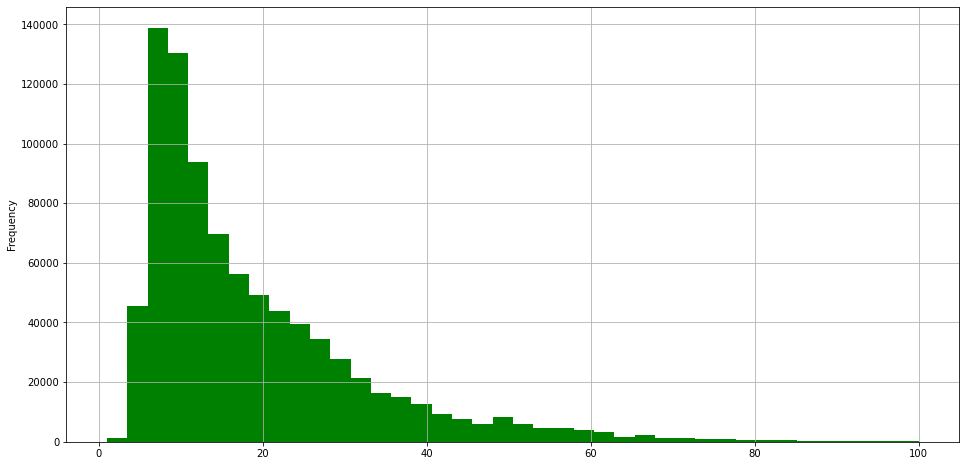

In [32]:
fig, ax = plt.subplots(figsize=(16,8))
data['total_amount'].plot.hist(range=(1,100), bins=40, grid=True, color='green')


Исходя из графика можно сделать вывод о том, что распределение стоимости поездок на такси не является нормальным, оно наклон в правую сторону (right (positevely) skewed distribution) и достаточно длинный "хвост". Данное распределение можно объяснить тем, что с увеличением дистанции поездки увеличивается и стоимость оплаты, которая включает в себя различные дополнительные сборы. Большинство поездок короткие и по стоиомсти входят в интервал от 5 до 15-18 долларов.

## Машинное обучение

Построим модель, которая будет предсказывать стоимость поездки в зависимости от определенных факторов.

In [33]:
# отберем числовые столбцы

columns = ['passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax', 'tolls_amount', 
           'improvement_surcharge', 'congestion_surcharge']

In [34]:
# отберем целевой стобец

target = data['total_amount']

In [35]:
# нормализуем данные

scaler = StandardScaler()
scaler.fit(data[columns]) 
scaled_df = scaler.transform(data[columns])

In [36]:
# используем линейную регрессию на наших данных

linear_regression_model = LinearRegression()
linear_regression_model.fit(scaled_df, target)
predictions = linear_regression_model.predict(scaled_df)
mse = mean_squared_error(target, predictions) 
mae = mean_absolute_error(target, predictions)

print("RMSE: {}".format(np.sqrt(mse)))
print("MAE: {}".format(np.sqrt(mae)))


RMSE: 2.1385254010364645
MAE: 1.0632016595976064


In [37]:
# посмотрим на коэффициенты, которым научилась наша модель по всем показателям

linear_regression_model.fit(scaled_df, target) 
sorted(list(zip(data[columns], linear_regression_model.coef_)), 
       key=lambda x: abs(x[1]))


[('trip_distance', -0.0025304718274603137),
 ('passenger_count', 0.025731730310413457),
 ('improvement_surcharge', 0.22283230077390148),
 ('mta_tax', 0.46347025323105595),
 ('extra', 0.7638626192214473),
 ('congestion_surcharge', 1.3503887416837792),
 ('tolls_amount', 1.4601417204569247),
 ('fare_amount', 12.96189058886882)]

In [38]:
# разделим данные на обучающий и тестовый датасеты

X_train, X_test, y_train, y_test = train_test_split(scaled_df, 
                                                    target, 
                                                    test_size=0.33, 
                                                    random_state=42)

In [39]:
# применим линейную регрессию и выясним MSE для обучающего и тестового набора данных

linear_regression_model = LinearRegression()
linear_regression_model.fit(X_train, y_train)

train_predictions = linear_regression_model.predict(X_train) 
test_predictions = linear_regression_model.predict(X_test)

train_mse = mean_squared_error(y_train, train_predictions)
test_mse = mean_squared_error(y_test, test_predictions)

print("Train MSE: {}".format(train_mse))
print("Test MSE: {}".format(test_mse))



Train MSE: 4.916513509954743
Test MSE: 36.42645367873576


Оба значения довольно далеки друг от друга, что говорит о проблеме с переобучением. Один из способов снизить высокую дисперсию, применить регуляризацию. Прежде чем перейти к регуляризации, постоим график кривой обучения, отображающей функцию ошибок (MSE) с различными объемами данных, используемых для тренировки. Этот график поможет разобраться со значениями дисперсии и смещения.

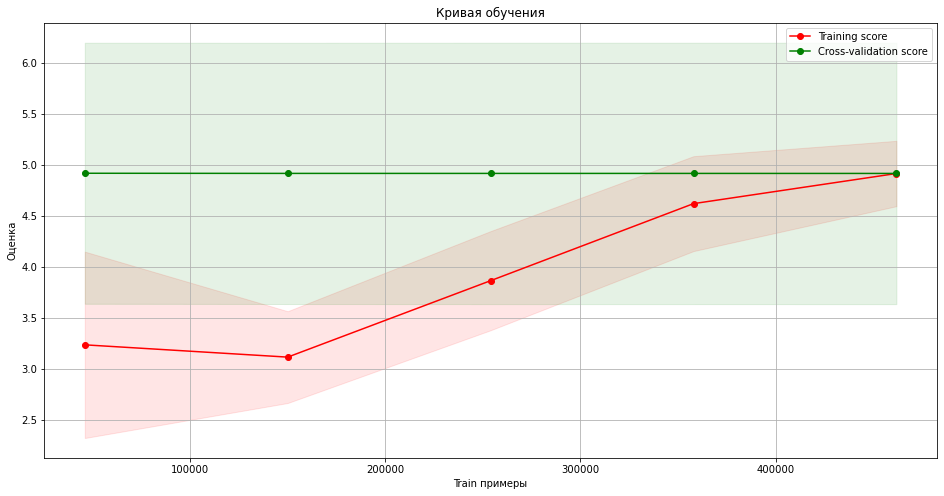

In [40]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
 
    plt.figure(figsize=(16,8))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Train примеры")
    plt.ylabel("Оценка")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=make_scorer(mean_squared_error))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Сross-validation score")

    plt.legend(loc="best")
    return plt

plot_learning_curve(linear_regression_model, 
                    "Кривая обучения", 
                    X_train, 
                    y_train, 
                    cv=5);



Мы видим, что оценка за обучение находится между максимальным и средним уровнем, и оценка перекрестной проверки может быть увеличена с помощью большего количества обучающих выборок. По мере увеличения данных мы начинаем улучшать оценку за обучение, оценка перекрестной проверки и оценка за обучение сходятся в точке, где количество обучающих примеров более 450 000. Это говорит нам о том, что нужно менять сложность модели, добавление данных в этом случае не поможет.

In [41]:
# Регуляризация

encv = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], alphas=[.1, 1, 10]) 
encv.fit(X_train, y_train) 

train_predictions = encv.predict(X_train) 
test_predictions = encv.predict(X_test) 
print("Train MSE: {}".format(mean_squared_error(y_train, train_predictions)))
print("Test MSE: {}".format(mean_squared_error(y_test, test_predictions)))



Train MSE: 5.020487045708101
Test MSE: 3.962603545329758


Таким образом, мы получили MSE для обучающего и тестового набора данных близкими по значению. Можно сделать вывод, что после применения регуляризации модель стала предсказывать более точно.
